In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import glob

In [10]:
# Define the directories containing the files
ce_dir = 'D:/Data2_MAC/Normal/CE/180/alpha/'
oe_dir = 'D:/Data2_MAC/Normal/OE/180/alpha/'

# Get a list of filenames for ce_data
ce_files = glob.glob(ce_dir + 'ce_*.csv')

# Get a list of filenames for oe_data
oe_files = glob.glob(oe_dir + 'oe_*.csv')

# Read and concatenate ce_data
ce_data = pd.concat((pd.read_csv(file, header=None) for file in ce_files), ignore_index=True)

# Read and concatenate oe_data
oe_data = pd.concat((pd.read_csv(file, header=None) for file in oe_files), ignore_index=True)

# Assuming ce_data and oe_data are already defined
ce_data['label'] = 0
oe_data['label'] = 1
all_data = pd.concat([ce_data, oe_data])

# Shuffle data
all_data = all_data.sample(frac=1).reset_index(drop=True)

# Separate features and labels
X = all_data.drop(columns=['label'])
y = all_data['label']

In [12]:


# Assuming X is your DataFrame and y is your target variable
# Compute additional features
X['mean'] = X.mean(axis=1)
X['minimum'] = X.min(axis=1)
X['maximum'] = X.max(axis=1)
X['std'] = X.std(axis=1)
# X['entropy'] = X.apply(compute_entropy, axis=1)
X['skewness'] = X.skew(axis=1)
X['kur'] = X.kurtosis(axis=1)
X['median'] = X.median(axis=1)
X['variance'] = X.var(axis=1)
X['range'] = X['maximum'] - X['minimum']
X['sum'] = X.sum(axis=1)
X['cov'] = X['std'] / X['mean']
X['iqr'] = X.apply(lambda row: np.percentile(row, 75) - np.percentile(row, 25), axis=1)
X['q1'] = X.apply(lambda row: np.percentile(row, 25), axis=1)
X['q3'] = X.apply(lambda row: np.percentile(row, 75), axis=1)
X['rms'] = np.sqrt((X**2).mean(axis=1))

# Convert column names to strings
X.columns = X.columns.astype(str)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Preprocessing - Imputation and Scaling
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Model Selection and Training
# 1. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 2. Support Vector Classifier (SVM)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 3. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 4. K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# 5. Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train_scaled, y_train)

# Model Evaluation
models = [
    ('Random Forest', rf_model), 
    ('SVM', svm_model), 
    ('Logistic Regression', lr_model), 
    ('KNN', knn_model), 
    ('Gradient Boosting', gbc_model)
]

accuracies = []
for name, model in models:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"=== {name} ===")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print()


=== Random Forest ===
Accuracy: 0.6988770685579196
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      1714
           1       0.69      0.71      0.70      1670

    accuracy                           0.70      3384
   macro avg       0.70      0.70      0.70      3384
weighted avg       0.70      0.70      0.70      3384

Confusion Matrix:
 [[1179  535]
 [ 484 1186]]

=== SVM ===
Accuracy: 0.6873522458628841
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.60      0.66      1714
           1       0.66      0.77      0.71      1670

    accuracy                           0.69      3384
   macro avg       0.69      0.69      0.69      3384
weighted avg       0.69      0.69      0.69      3384

Confusion Matrix:
 [[1035  679]
 [ 379 1291]]

=== Logistic Regression ===
Accuracy: 0.6347517730496454
Classification Report:
               precision    reca

In [ ]:
# Plotting Box Plot for Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x=[name for name, _ in models], y=accuracies, palette='Blues', linewidth=2.5, flierprops=dict(marker='o', markersize=8))
plt.xlabel('Classifier', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Classifier Comparison - Accuracy', fontsize=16)
plt.ylim(0.5, 1.0)  # Adjust y-axis limits if needed
plt.xticks(fontsize=12, rotation=45)

plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

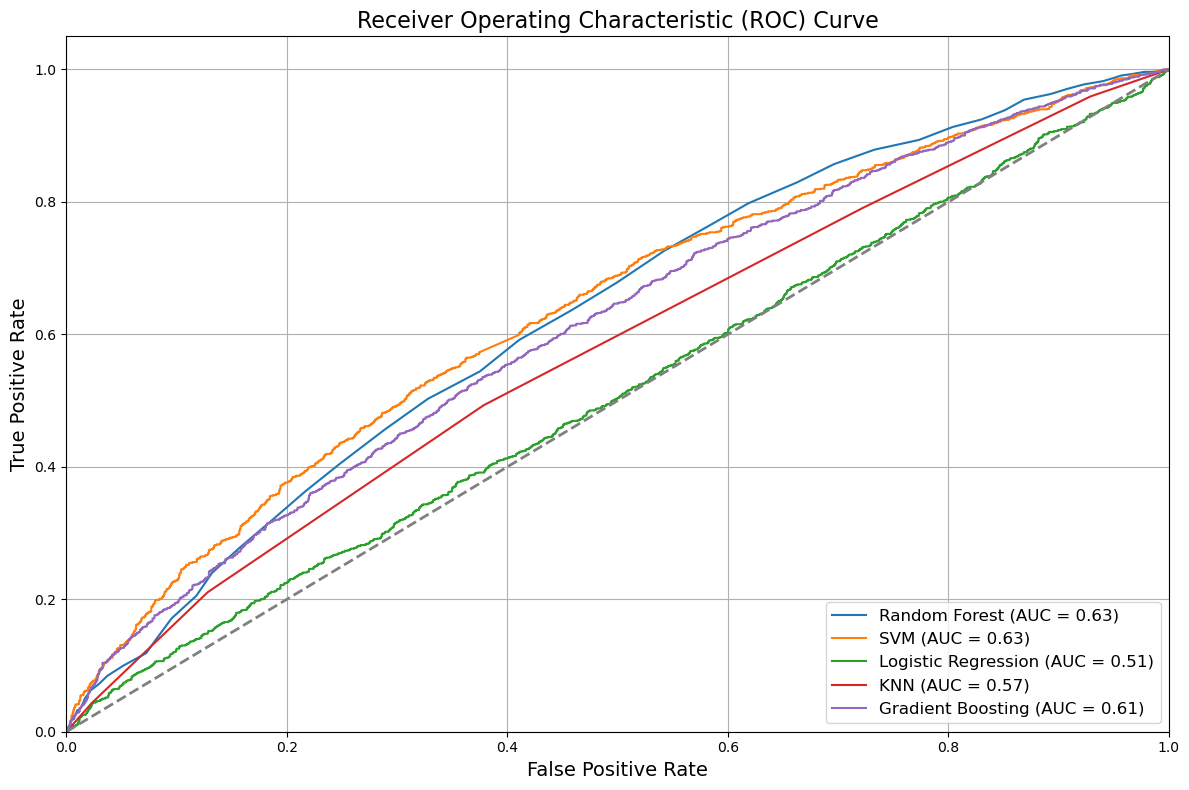

In [82]:
# Model Evaluation and ROC Curve
plt.figure(figsize=(12, 8))

for name, model in models:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = model.decision_function(X_test_scaled)
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# Find the index of the point closest to (0,1)
idx = np.argmax(tpr - fpr)

# Get the corresponding threshold
best_threshold = thresholds[idx]

print(f"Best threshold: {best_threshold:.4f}")


Best threshold: 0.4976
